<a href="https://colab.research.google.com/github/SarkarPriyanshu/USHousingMarketAnalysis/blob/main/03_Model_Development_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install -q feature-engine

In [121]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import BoxCoxTransformer
from sklearn.linear_model import LinearRegression,BayesianRidge,ElasticNet,SGDRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import GridSearchCV
from joblib import dump

plt.style.use('ggplot')

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [15]:
df = pd.read_csv('/content/USHousing',parse_dates=['DATE']).iloc[:,2:]

In [16]:
df.shape

(86, 8)

In [17]:
df.sample(5)

,CSUSHPISA,EVACANTUSQ176N,GDP,INTDSRUSM193N,MSACSR,PERMIT,UMCSENT,MSPUS
48,139.154,18519.0,16207.115,0.75,4.9,732.0,76.4,238700.0
5,113.491,13988.0,10598.020,3.25,4.2,1598.0,92.4,172500.0
69,191.450,17684.0,19692.595,1.75,5.8,1254.0,93.4,320500.0
62,174.792,17288.0,18435.137,0.75,5.6,1160.0,90.0,302500.0
0,102.922,13773.0,10247.720,5.50,4.4,1597.0,109.2,163200.0


# Model Development

In [18]:
# Splitting the dataset into features (X) and target variable (y)

data_boxcox, lambda_boxcox = stats.boxcox(df['CSUSHPISA'])
X, y = df.drop('CSUSHPISA', axis=1), data_boxcox

# Splitting the data into training and testing sets
# The test set will be 30% of the data, using a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60, 7), (26, 7), (60,), (26,))

In [22]:
models_list = [{'LinearRegression':LinearRegression()},{'BayesianRidge':BayesianRidge()},{'ElasticNet':ElasticNet()},{'SGDRegressor':SGDRegressor()},{'SVR':SVR(kernel="linear")}]

In [23]:
# Initialize an empty list to store results
results_list = list()

# Loop through models_list
for model_info in models_list:
  # Create a pipeline for each model
  pipe = Pipeline([
        # Apply BoxCoxTransformer to variables in df columns
        ('BoxCoxTransformer', BoxCoxTransformer(variables=list(df.columns[1:]))),
        # Standardize the features
        ('StandardScaler', StandardScaler()),
        # Add the specific model to the pipeline
        (list(model_info.keys())[0], list(model_info.values())[0])  # model_info[0] is the model name, model_info[-1] is the model object
  ])

  # Fit the pipeline on training data
  pipe.fit(X_train, y_train)

  # Make predictions on training and test data
  X_train_predictions = pipe.predict(X_train)
  X_test_predictions = pipe.predict(X_test)

  # Store model name and its performance metrics in results_list
  results_list.append({
        'Model Name': list(model_info.keys())[0],
        'Model_Coef_Intercept':{'coef':pipe[list(model_info.keys())[0]].coef_,'intercept':pipe[list(model_info.keys())[0]].intercept_},
        'Train Data R2': r2_score(y_train, X_train_predictions),
        'Test Data R2': r2_score(y_test, X_test_predictions),
        'Test Data Residual':y_test-X_test_predictions,
        'R2 Diff': r2_score(y_train, X_train_predictions) - r2_score(y_test, X_test_predictions),
        'Train Data RMSE': np.sqrt(mean_squared_error(y_train, X_train_predictions)),
        'Test Data RMSE': np.sqrt(mean_squared_error(y_test, X_test_predictions)),
        'RMSE Diff': np.sqrt(mean_squared_error(y_train, X_train_predictions)) -  np.sqrt(mean_squared_error(y_test, X_test_predictions))
  })


In [24]:
# Initializing variables to track the best models and their respective metrics

# Loop through the results_list to analyze model performance
for result in results_list:
    # Display performance metrics for each model
    print(f"Name: {result['Model Name']:{25}} TrainR2: {np.round(result['Train Data R2'],2)}, TestR2: {np.round(result['Test Data R2'],2)}, DiffR2: {np.round(result['R2 Diff'],2)}")
    print(f"Name: {result['Model Name']:{25}} TrainRMSE: {np.round(result['Train Data RMSE'],2)}, TestRMSE: {np.round(result['Test Data RMSE'],2)}, DiffRMSE: {np.round(result['RMSE Diff'],2)}")
    print()
    print()


Name: LinearRegression          TrainR2: 0.97, TestR2: 0.95, DiffR2: 0.02
Name: LinearRegression          TrainRMSE: 0.08, TestRMSE: 0.09, DiffRMSE: -0.01


Name: BayesianRidge             TrainR2: 0.97, TestR2: 0.95, DiffR2: 0.02
Name: BayesianRidge             TrainRMSE: 0.08, TestRMSE: 0.09, DiffRMSE: -0.01


Name: ElasticNet                TrainR2: 0.0, TestR2: -0.07, DiffR2: 0.07
Name: ElasticNet                TrainRMSE: 0.49, TestRMSE: 0.44, DiffRMSE: 0.05


Name: SGDRegressor              TrainR2: 0.94, TestR2: 0.86, DiffR2: 0.08
Name: SGDRegressor              TrainRMSE: 0.12, TestRMSE: 0.16, DiffRMSE: -0.04


Name: SVR                       TrainR2: 0.97, TestR2: 0.96, DiffR2: 0.01
Name: SVR                       TrainRMSE: 0.09, TestRMSE: 0.09, DiffRMSE: -0.0




## Model Selection

Text(0.5, 1.0, 'skew : 0.43, mean: 164.95, median: 163.48 ')

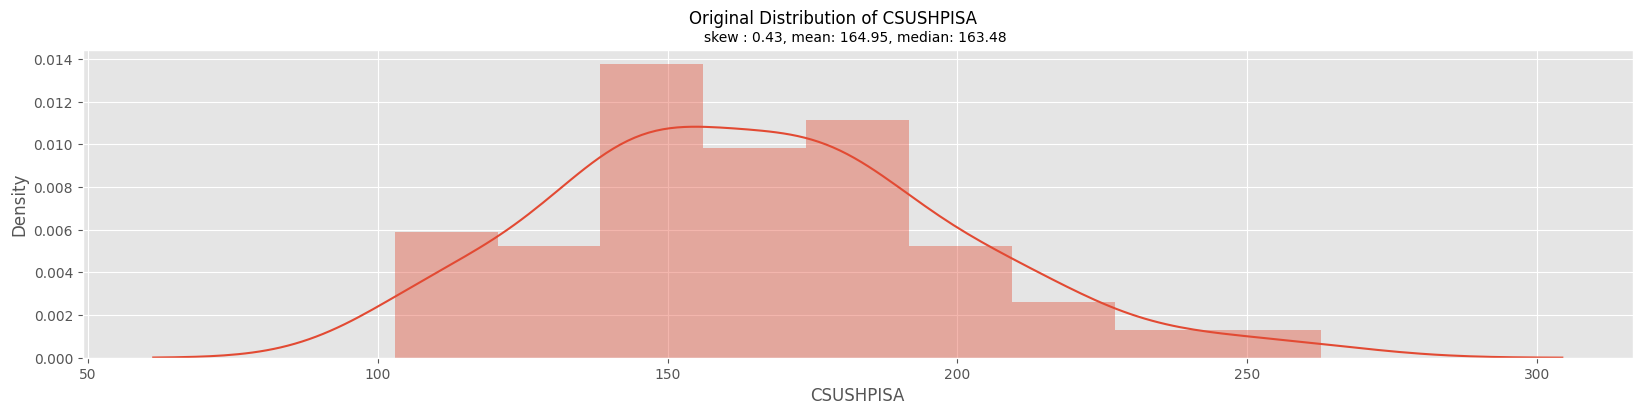

In [33]:
fig, ax = plt.subplots( figsize=(20, 4))
fig.suptitle('Original Distribution of CSUSHPISA', fontsize=12)

# Original Distribution and Boxplot
sns.distplot(df['CSUSHPISA'], ax=ax)
skew = np.round(stats.skew(df['CSUSHPISA']), 2)
ax.set_title(f'skew : {skew}, mean: {np.round(df["CSUSHPISA"].mean(),2)}, median: {np.round(df["CSUSHPISA"].median(),2)} ',fontsize=10)

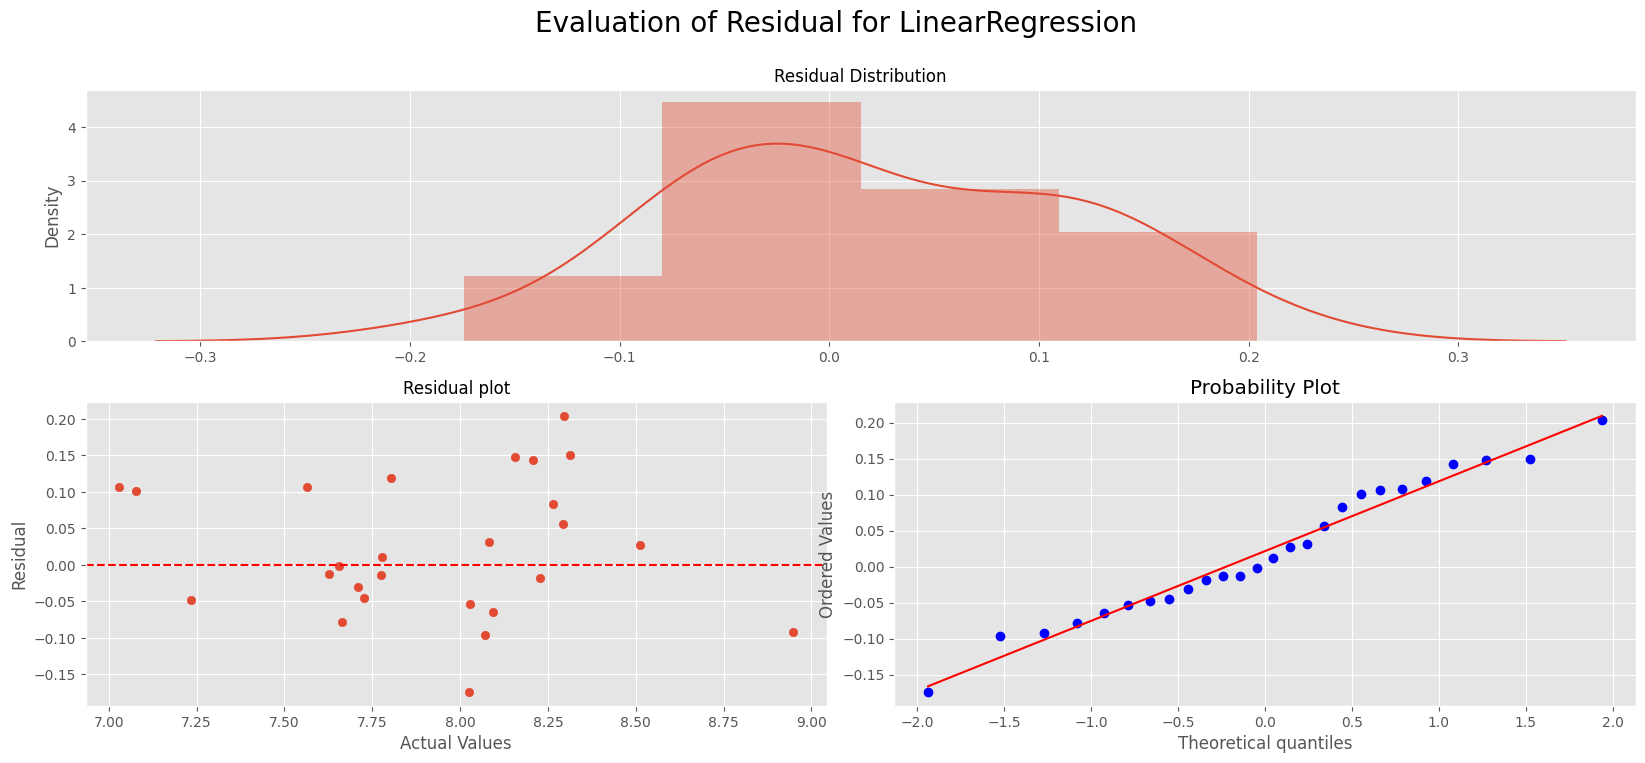

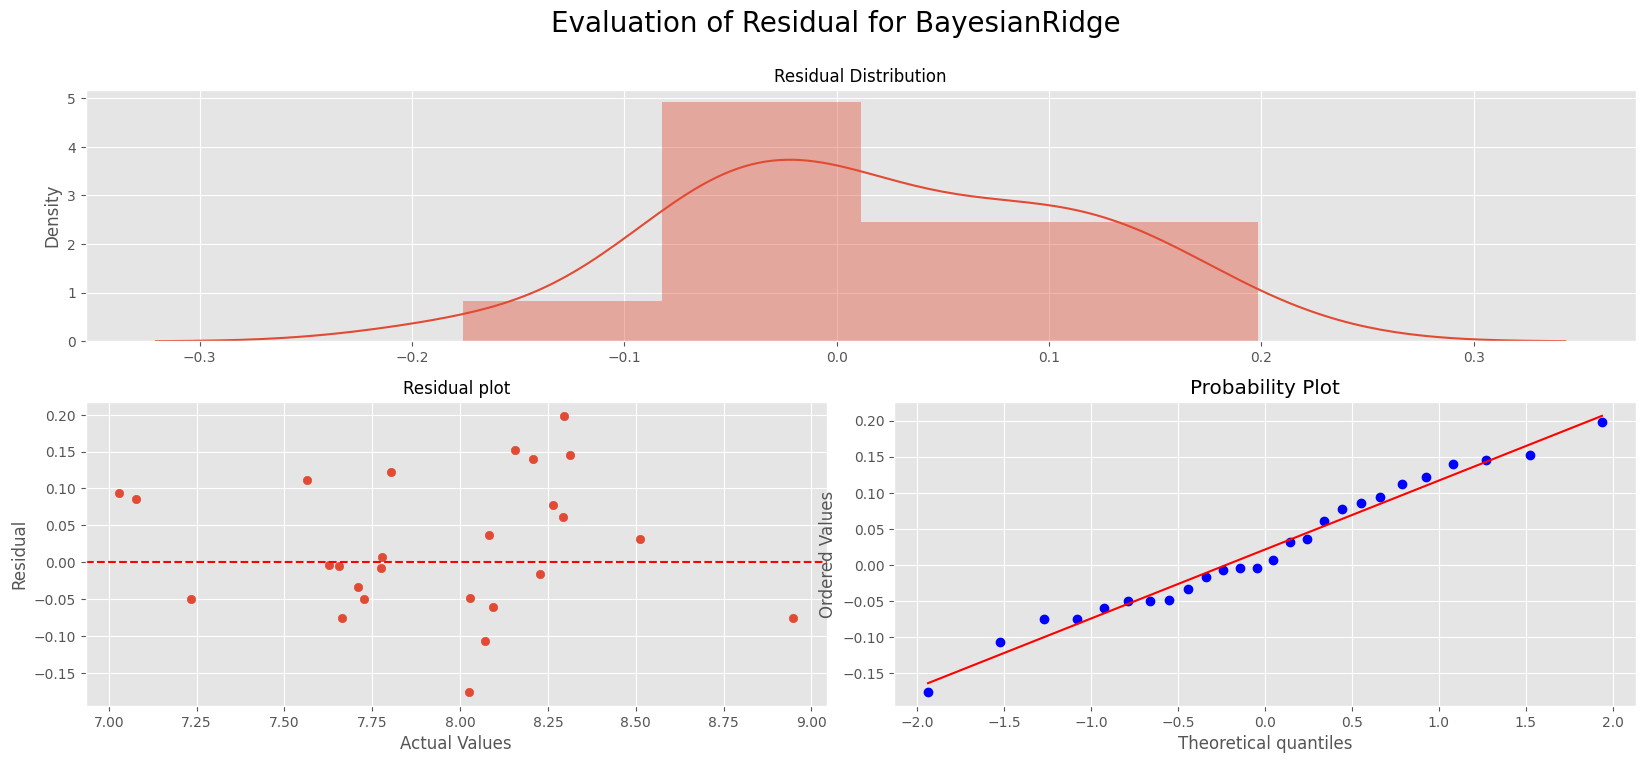

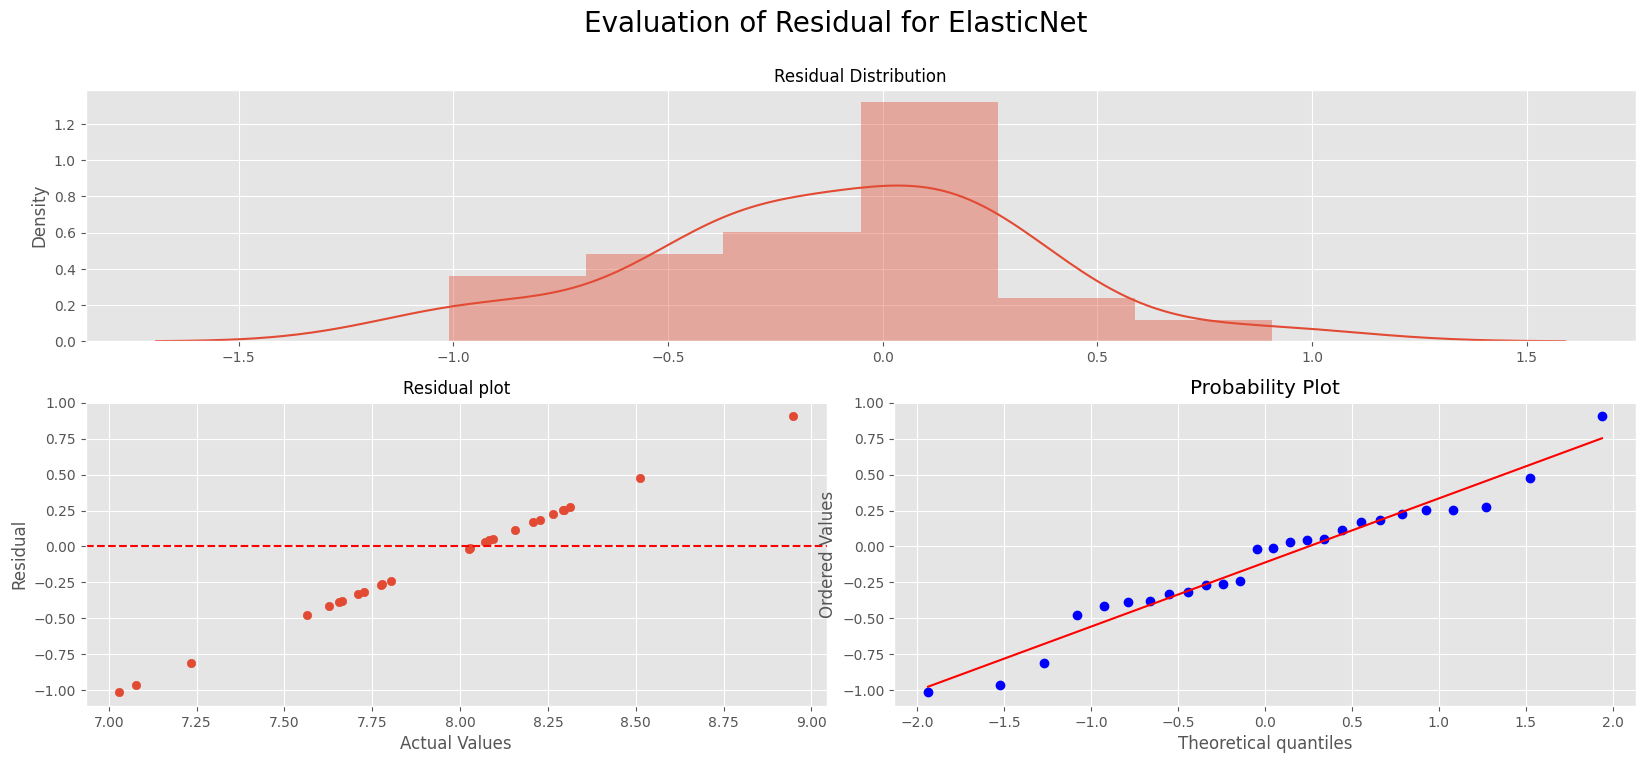

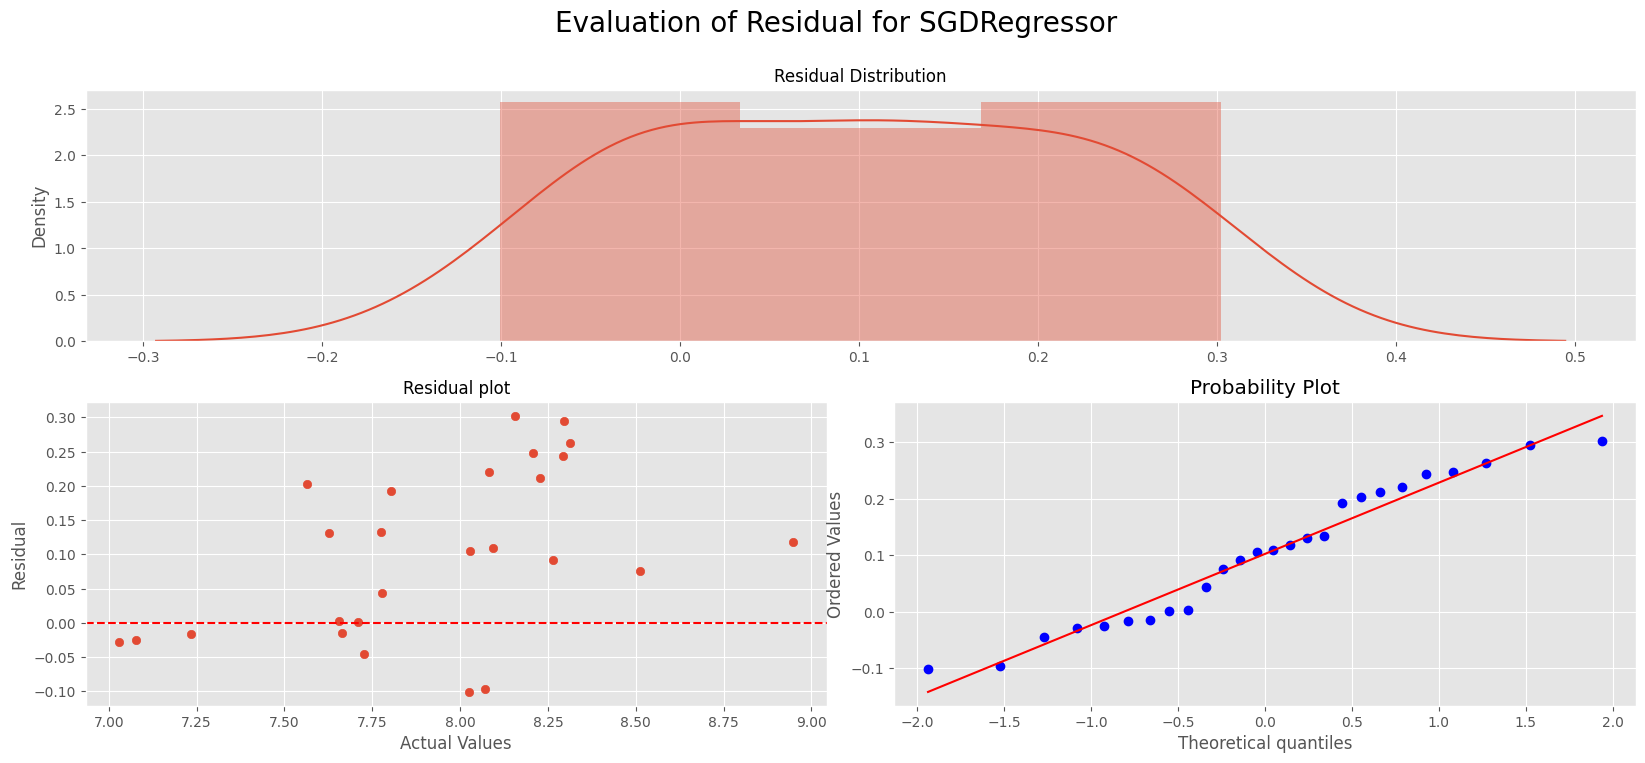

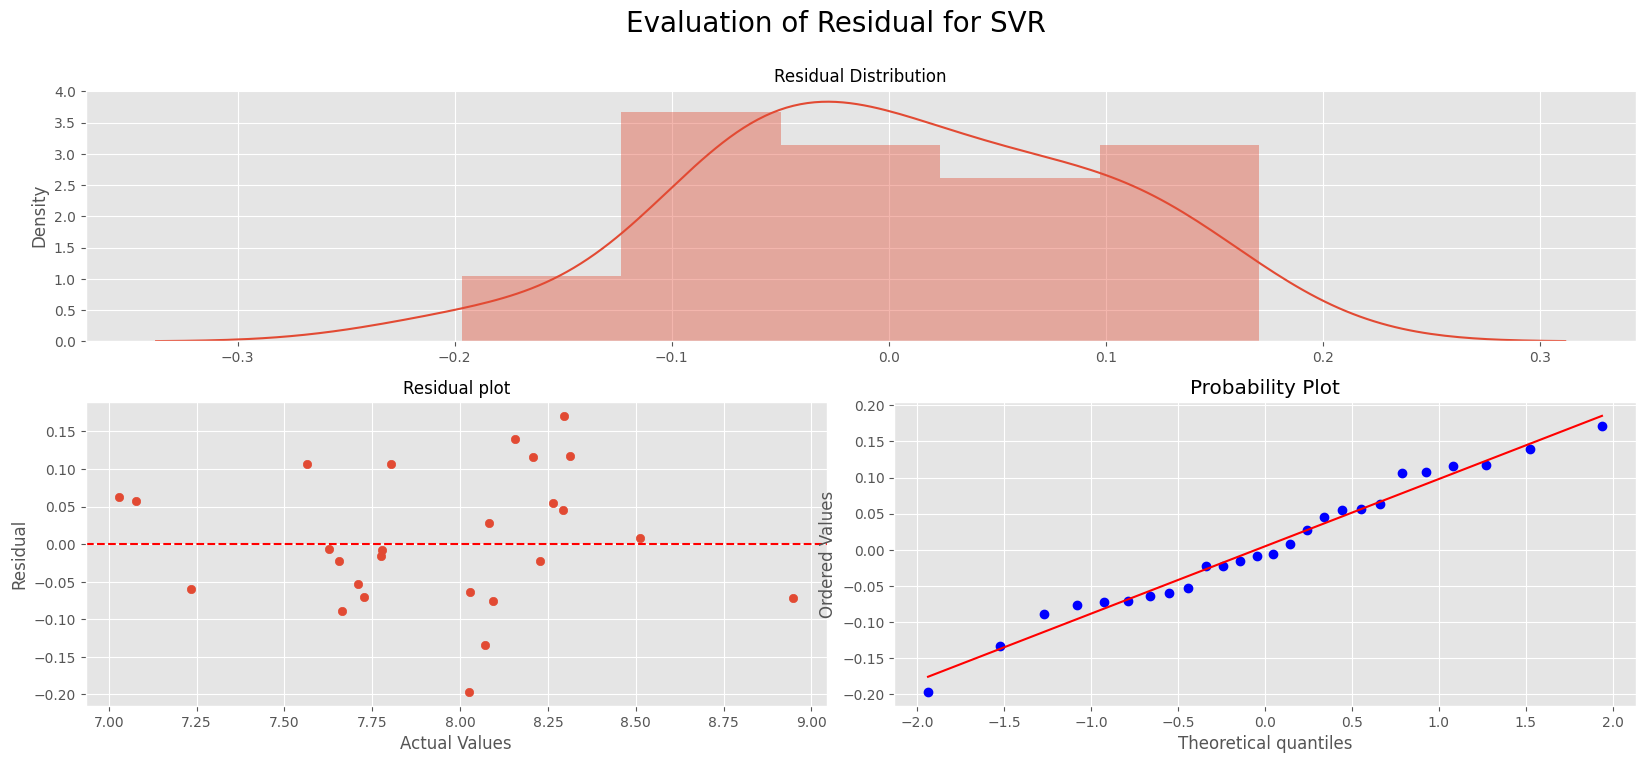

In [34]:
# Loop through each result in results_list
for result in results_list:
    # Create a new figure
    fig = plt.figure(figsize=(20, 8))
    fig.suptitle(f'Evaluation of Residual for {result["Model Name"]}', fontsize=20)

    # Create a grid for subplots
    gs = grid.GridSpec(ncols=4, nrows=12)

    # Add subplot for Residual Distribution
    ax1 = fig.add_subplot(gs[:5, :])
    ax1.set_title('Residual Distribution', fontsize=12)
    sns.distplot(result['Test Data Residual'], ax=ax1)

    # Add subplot for Residual plot
    ax2 = fig.add_subplot(gs[6:, :2])
    ax2.set_title('Residual plot', fontsize=12)
    ax2.scatter(y_test, result['Test Data Residual'])
    ax2.axhline(y=0, color='r', ls='--')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Residual')

    # Add subplot for Probability plot
    ax3 = fig.add_subplot(gs[6:, 2:])
    ax3.set_title('Probability plot', fontsize=12)
    stats.probplot(result['Test Data Residual'], plot=ax3)

    # Display the plot
    plt.show()


In [36]:
LinearRregrssorResult,SVR_Result = results_list[0],results_list[-1]

In [46]:
# Linear Regressor Model Coefficients
for key,value in zip(X_train.columns,LinearRregrssorResult['Model_Coef_Intercept']['coef']):
  print(f"{key:{20}} {value:{10}}")

EVACANTUSQ176N       0.03308013108143368
GDP                  0.2778591421762549
INTDSRUSM193N        -0.024134697564352048
MSACSR               0.16675078549632033
PERMIT               0.300710960307199
UMCSENT              -0.08532911707963087
MSPUS                0.18932153709615693


In [60]:
# SVR Model Coefficients
for key,value in zip(X_train.columns,SVR_Result['Model_Coef_Intercept']['coef'][0]):
  print(f"{key:{20}} {value:{10}}")

EVACANTUSQ176N       0.02234715941779286
GDP                  0.2342977516300706
INTDSRUSM193N        -0.014380254035742723
MSACSR               0.16316979250474528
PERMIT               0.2703875977671819
UMCSENT              -0.07992707282517686
MSPUS                0.23550905537209044


### Observation Of Model Development
<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li><strong>Question: Why not use tree-based or deep neural network?</strong>
      <ul>
        <li>We do not want to draw decision boundaries because, as we saw while analyzing things like GDP, Median Sales, or Vacant, or any other aspect affects our Target columns.</li>
        <li>The point here is in the real world, we can't say things go as we expected. That's why we want our model to learn from real-time data observations and predict outcomes based on that.</li>
        <li>In tree-based models, we draw decision boundaries that are good for scenarios with limited possibilities.</li>
        <li>Then what is wrong with Neural Network? We want to know which factors affect more or less in predicting outcomes, which is not known if we work with neural networks.</li>
        <li>Hence, we go with Linear Models. The advantage is they are less complex, and we say there is a linear correlation between the target and independent columns.</li>
      </ul>
     <li><strong>Question: What features contributes in predicting House Price Indexes (CSUSHPISA)</strong>
      <ul>
          <li>We are going to experement with `Linear Regressor` and `SVM` becuase they are best performers.</li>
          <li>Factors (Feature) that have high contributes in predicting target column are as follows</li>
            <ul>
              <li>GDP</li>
              <li>MSACSR</li>
              <li>PERMIT</li>
              <li>MSPUS</li>
            </ul>
      </ul>
    </li>
  </ul>
</blockquote>


## Experimentation
<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li>Experiment with Linear Regressor & SVM model</li>
    <li>Trying Different Parameters</li>
    <li>Evaluating Result</li>
  </ul>
</blockquote>


###  Linear Regressor Model

In [97]:
pipe = Pipeline([
        # Apply BoxCoxTransformer to variables in df columns
        ('BoxCoxTransformer', BoxCoxTransformer(variables=list(df.columns[1:]))),
        # Standardize the features
        ('StandardScaler', StandardScaler()),
        # Add the specific model to the pipeline
        ('LinearRegression',LinearRegression())  # model_info[0] is the model name, model_info[-1] is the model object
  ])

param_grid={
    'LinearRegression__positive':[True,False]
}

In [98]:
GScv = GridSearchCV(pipe,param_grid,scoring='neg_root_mean_squared_error',cv=5)

In [99]:
GScv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('BoxCoxTransformer',
                                        BoxCoxTransformer(variables=['EVACANTUSQ176N',
                                                                     'GDP',
                                                                     'INTDSRUSM193N',
                                                                     'MSACSR',
                                                                     'PERMIT',
                                                                     'UMCSENT',
                                                                     'MSPUS'])),
                                       ('StandardScaler', StandardScaler()),
                                       ('LinearRegression',
                                        LinearRegression())]),
             param_grid={'LinearRegression__positive': [True, False]},
             scoring='neg_root_mean_squared_error')

In [100]:
GScv.best_params_

{'LinearRegression__positive': False}

In [101]:
GScv.best_score_

-0.11987354037627415

In [102]:
X_test_predictions = GScv.predict(X_test)

In [103]:
np.sqrt(mean_squared_error(y_test, X_test_predictions))

0.09460729605636911

In [104]:
r2_score(y_test, X_test_predictions)

0.9510056945894918

In [105]:
pd.DataFrame(GScv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LinearRegression__positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013916,0.001747,0.004913,0.000584,True,{'LinearRegression__positive': True},-0.083998,-0.123638,-0.162182,-0.079871,-0.256592,-0.141256,0.064957,2
1,0.013402,0.000681,0.004503,0.000111,False,{'LinearRegression__positive': False},-0.082686,-0.109504,-0.116578,-0.096928,-0.193672,-0.119874,0.038663,1


In [106]:
LinearR_Residuals = y_test - X_test_predictions

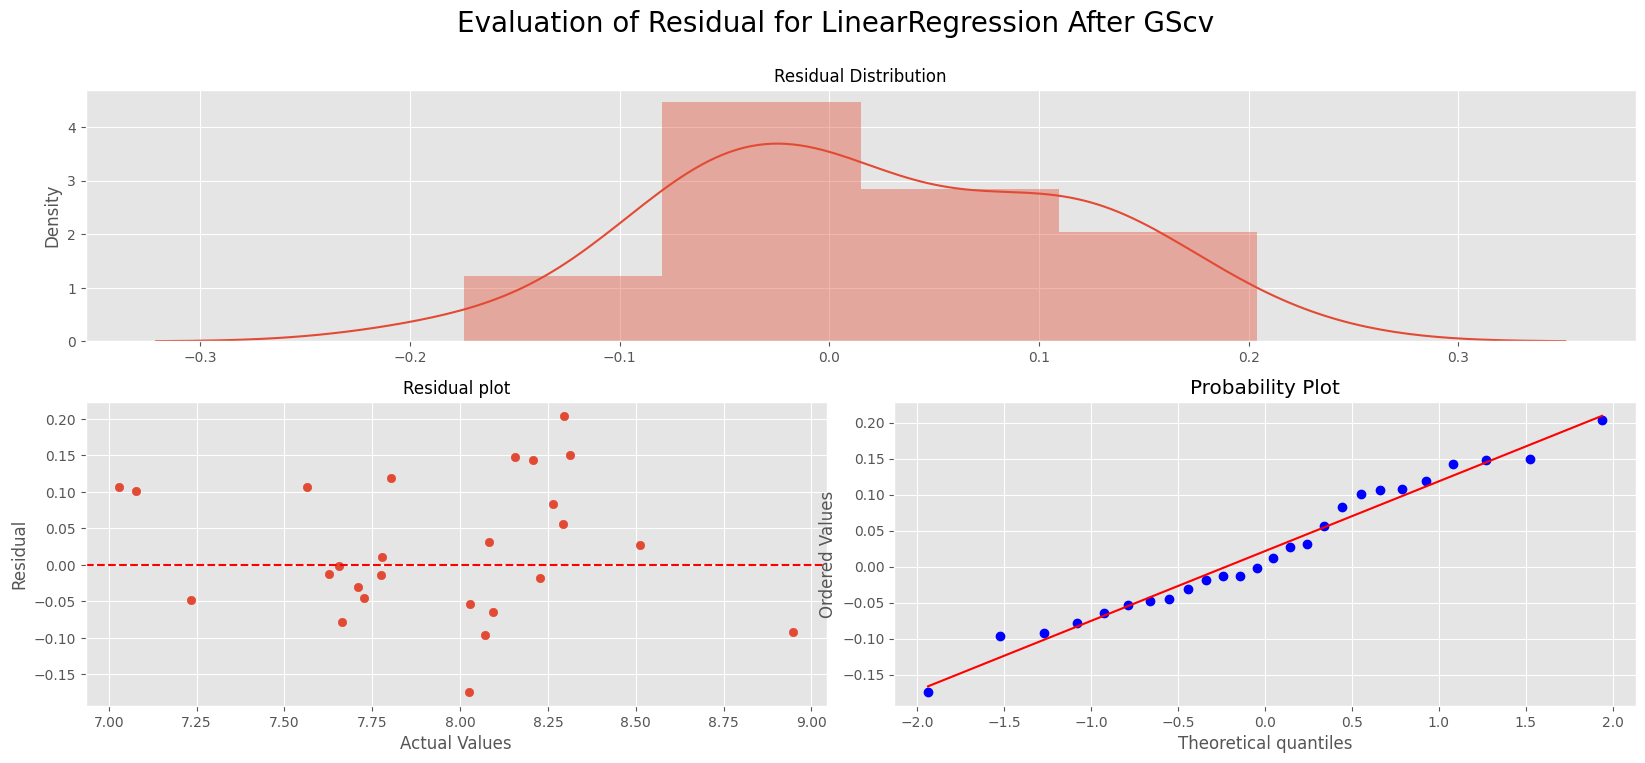

In [108]:
# Create a new figure
fig = plt.figure(figsize=(20, 8))
fig.suptitle(f'Evaluation of Residual for LinearRegression After GScv', fontsize=20)

# Create a grid for subplots
gs = grid.GridSpec(ncols=4, nrows=12)

# Add subplot for Residual Distribution
ax1 = fig.add_subplot(gs[:5, :])
ax1.set_title('Residual Distribution', fontsize=12)
sns.distplot(LinearR_Residuals, ax=ax1)

# Add subplot for Residual plot
ax2 = fig.add_subplot(gs[6:, :2])
ax2.set_title('Residual plot', fontsize=12)
ax2.scatter(y_test, LinearR_Residuals)
ax2.axhline(y=0, color='r', ls='--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Residual')

# Add subplot for Probability plot
ax3 = fig.add_subplot(gs[6:, 2:])
ax3.set_title('Probability plot', fontsize=12)
stats.probplot(LinearR_Residuals, plot=ax3)

# Display the plot
plt.show()


### Support Vector Regressor

### Note
#### C:

<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li><strong>Too Small:</strong> A very small C might result in a model that is too tolerant of misclassified points, leading to a larger-margin hyperplane. This can result in underfitting, especially if the data is complex.</li>
    <li><strong>Moderate:</strong> A moderate C balances between allowing some misclassifications and fitting the data well. It usually gives a good generalization on unseen data.</li>
    <li><strong>Too High:</strong> A very high C might lead to overfitting, where the model tries too hard to fit all training points precisely. This could lead to a smaller-margin hyperplane that doesn’t generalize well to new data.</li>
  </ul>
</blockquote>

<strong>Best Suited Situation:</strong>
<ul>
  <li>Use a smaller C when you prefer a simpler model or when there's a lot of noise in the data.</li>
  <li>Use a higher C when you want your model to focus on fitting the training data more precisely and are less concerned about overfitting.</li>
</ul>

#### Gamma (γ):

<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li><strong>Too Small:</strong> A small gamma implies a larger similarity radius, leading to a smoother decision boundary. This might cause underfitting, especially in cases where the data is complex and requires a more nuanced separation.</li>
    <li><strong>Moderate:</strong> A moderate gamma usually results in a good balance, capturing the complexity of the data without overfitting.</li>
    <li><strong>Too High:</strong> A high gamma implies a smaller similarity radius, which might lead to overfitting by capturing noise in the data and not generalizing well to unseen data.</li>
  </ul>
</blockquote>

<strong>Best Suited Situation:</strong>
<ul>
  <li>Use a smaller gamma for smoother decision boundaries and when dealing with high-dimensional data.</li>
  <li>Use a higher gamma for more intricate decision boundaries and lower-dimensional data.</li>
</ul>

#### Epsilon (ε):

<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li><strong>Too Small:</strong> A very small epsilon may result in a model that is too strict, allowing almost no errors within the margin. This might cause overfitting or a model that is too sensitive to noise.</li>
    <li><strong>Moderate:</strong> A moderate epsilon allows for some tolerance for errors, leading to a good balance between fitting the data and generalization.</li>
    <li><strong>Too High:</strong> A very high epsilon might lead to a model that is too lenient, allowing too many errors. This can cause underfitting or a model that lacks precision.</li>
  </ul>
</blockquote>

<strong>Best Suited Situation:</strong>
<ul>
  <li>Use a smaller epsilon for more precise modeling where errors need to be minimized.</li>
  <li>Use a higher epsilon when a more relaxed fitting is acceptable and when dealing with noisy data.</li>
</ul>


In [110]:
pipe = Pipeline([
        # Apply BoxCoxTransformer to variables in df columns
        ('BoxCoxTransformer', BoxCoxTransformer(variables=list(df.columns[1:]))),
        # Standardize the features
        ('StandardScaler', StandardScaler()),
        # Add the specific model to the pipeline
        ('SVR',SVR())  # model_info[0] is the model name, model_info[-1] is the model object
  ])

param_grid={
    'SVR__C':[0.001, 0.005, 0.01, 0.05, 1],
    'SVR__kernel':['linear', 'poly', 'rbf'],
    'SVR__gamma' : ['scale', 'auto'],
    'SVR__degree':[2, 3, 4],
    'SVR__epsilon':[0, 0.01, 0.1, 0.5, 1]
}

In [111]:
GScv = GridSearchCV(pipe,param_grid,scoring='neg_root_mean_squared_error',cv=5)

In [112]:
GScv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('BoxCoxTransformer',
                                        BoxCoxTransformer(variables=['EVACANTUSQ176N',
                                                                     'GDP',
                                                                     'INTDSRUSM193N',
                                                                     'MSACSR',
                                                                     'PERMIT',
                                                                     'UMCSENT',
                                                                     'MSPUS'])),
                                       ('StandardScaler', StandardScaler()),
                                       ('SVR', SVR())]),
             param_grid={'SVR__C': [0.001, 0.005, 0.01, 0.05, 1],
                         'SVR__degree': [2, 3, 4],
                         'SVR__epsilon': [0, 0.01, 0.1, 0.5, 1],
                         'SVR__gamma': ['scale', 'auto'],
                         'SVR__kernel': ['linear', 'poly', 'rbf']},
             scoring='neg_root_mean_squared_error')

In [113]:
GScv.best_params_

{'SVR__C': 0.05,
 'SVR__degree': 2,
 'SVR__epsilon': 0.01,
 'SVR__gamma': 'scale',
 'SVR__kernel': 'linear'}

In [114]:
GScv.best_score_

-0.1087368086647319

In [115]:
X_test_predictions = GScv.predict(X_test)

In [116]:
np.sqrt(mean_squared_error(y_test, X_test_predictions))

0.08673729757964327

In [117]:
r2_score(y_test, X_test_predictions)

0.9588179351074232

In [119]:
LinearR_Residuals = y_test - X_test_predictions

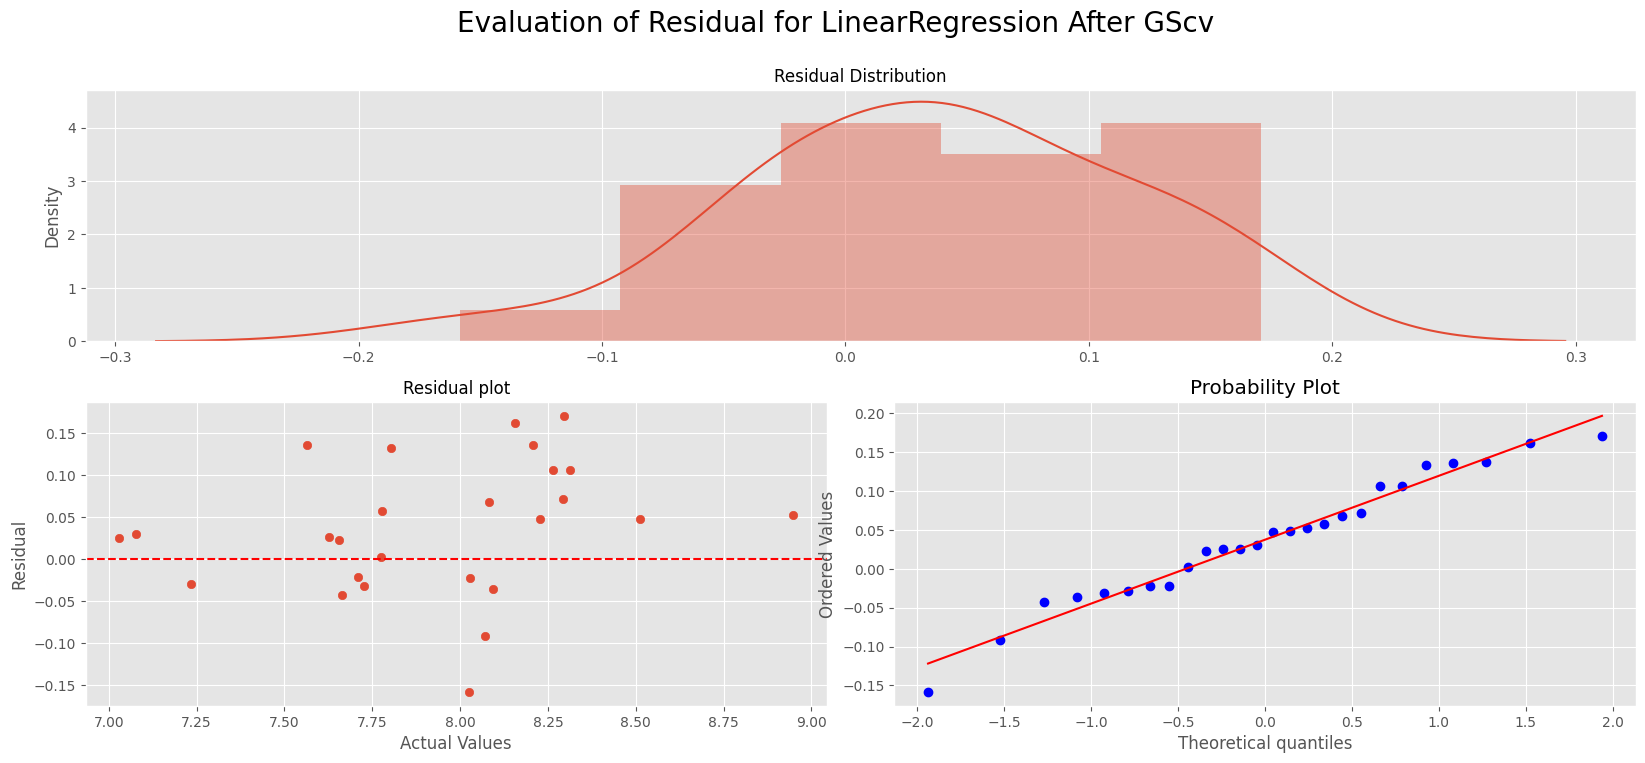

In [120]:
# Create a new figure
fig = plt.figure(figsize=(20, 8))
fig.suptitle(f'Evaluation of Residual for LinearRegression After GScv', fontsize=20)

# Create a grid for subplots
gs = grid.GridSpec(ncols=4, nrows=12)

# Add subplot for Residual Distribution
ax1 = fig.add_subplot(gs[:5, :])
ax1.set_title('Residual Distribution', fontsize=12)
sns.distplot(LinearR_Residuals, ax=ax1)

# Add subplot for Residual plot
ax2 = fig.add_subplot(gs[6:, :2])
ax2.set_title('Residual plot', fontsize=12)
ax2.scatter(y_test, LinearR_Residuals)
ax2.axhline(y=0, color='r', ls='--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Residual')

# Add subplot for Probability plot
ax3 = fig.add_subplot(gs[6:, 2:])
ax3.set_title('Probability plot', fontsize=12)
stats.probplot(LinearR_Residuals, plot=ax3)

# Display the plot
plt.show()


### Experimentation Observations / Conclusion
<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li>SVR model is clear better performer</li>
    <li>Parameters</li>
        <ul>
          <li>kernel = linear</li>
          <li>C = 0.05</li>
          <li>degree = 2</li>
          <li>epsilon = 0.01</li>
          <li>gamma = scale</li>
        </ul>
    <li>Factors (Feature) that have high contributes in predicting target column are as follows</li>
            <ul>
              <li>GDP (High)</li>
              <li>MSACSR (Moderate)</li>
              <li>PERMIT (High)</li>
              <li>MSPUS (High)</li>
            </ul>
  </ul>
</blockquote>


## Model Deployment
<blockquote style="background-color: #f7dc6f; padding: 10px; border-radius: 5px;">
  <ul>
    <li>Dump SVR model using Joblib</li>
  </ul>
</blockquote>


In [123]:
X_train.shape

(60, 7)

In [122]:
X_train.columns

Index(['EVACANTUSQ176N', 'GDP', 'INTDSRUSM193N', 'MSACSR', 'PERMIT', 'UMCSENT',
       'MSPUS'],
      dtype='object')

In [124]:
# Input dimensions : 7
# Feature Names : 'EVACANTUSQ176N', 'GDP', 'INTDSRUSM193N', 'MSACSR', 'PERMIT', 'UMCSENT', 'MSPUS'
# Save the trained model using joblib
dump(GScv, 'HousingPipe.joblib')

['HousingPipe.joblib']